In [ ]:
import os
import yfinance as yf
import pandas as pd
from utils.time_series import BasicTSTransformer,Indicators
import numpy as np
print(os.getcwd())

In [962]:
os.chdir('FinAT')

FileNotFoundError: [Errno 2] No such file or directory: 'FinAT'

In [1291]:
ticker = yf.Ticker('AMZN')
df = ticker.history('5y')

In [1292]:
#df = pd.read_csv('DNN.csv')

In [1293]:
BT = BasicTSTransformer()
Ind = Indicators()
ts_rets = BT.log_returns(df['Close'])

In [1294]:
es_2 = Ind.smoothed_rsi(ts_rets, 2)[30:] 
es_5 = Ind.smoothed_rsi(ts_rets, 5)[30:] - 50
es_10 = Ind.smoothed_rsi(ts_rets, 10)[30:] - 50
es_20 = Ind.smoothed_rsi(ts_rets, 20)[30:]- 50
es_30 = Ind.smoothed_rsi(ts_rets, 30)[30:] - 50
prices = df['Close']


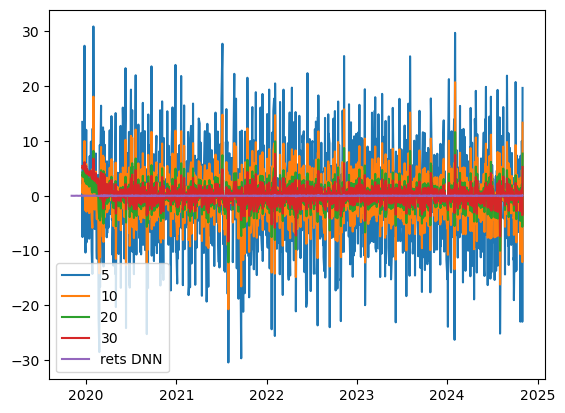

In [1295]:
import matplotlib.pyplot as plt
plt.plot(es_5,label = "5")
plt.plot(es_10, label = "10")
plt.plot(es_20, label = '20')
plt.plot(es_30,label = '30')
plt.plot(ts_rets, label = "rets DNN")
plt.legend()
plt.show()



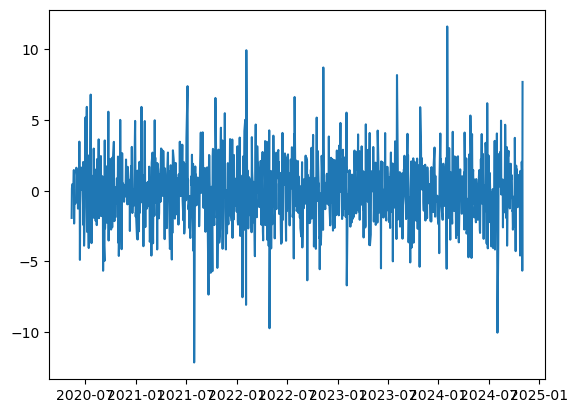

In [1296]:
plt.plot(es_20[100:], label = '20')


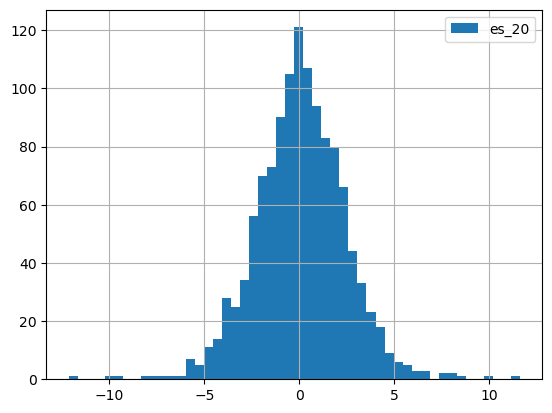

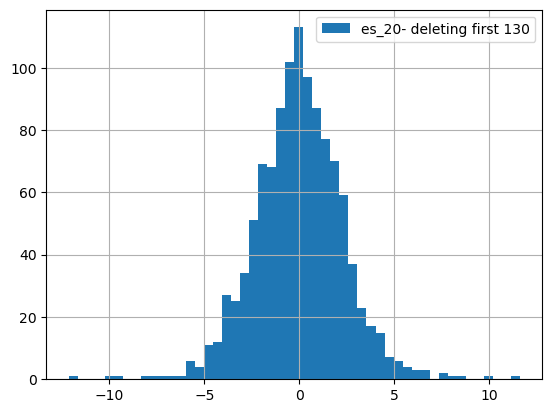

In [1297]:
#Essentially we should get rid of the first 100: Distribution is not normal
es_20.hist(bins = 50, label = "es_20")
plt.legend()
plt.show()
es_20[100:].hist(bins = 50, label = "es_20- deleting first 130")
plt.legend()
plt.show()

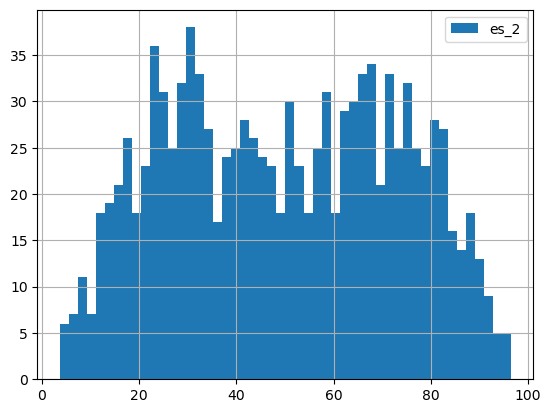

In [1298]:
es_2[100:].hist(bins = 50, label = "es_2")
plt.legend()
plt.show()


In [1299]:
#Distribution is not normal - following transformation makes it normal - it is inverse logistic composed with some
#normalization
import numpy as np
es_2_transformed = - np.log(2/(1 + 0.0099* (2*es_2 -100))-1)

<AxesSubplot:>

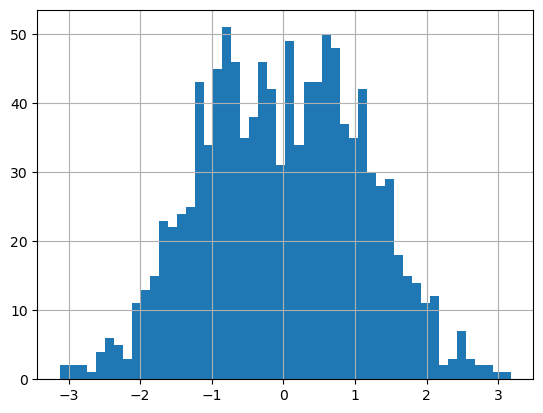

In [1300]:
es_2_transformed[100:].hist(bins = 50)

In [1301]:
X = es_20[100:]
y = es_2_transformed[100:]
prices = prices[100:]


In [1302]:
import torch
import torch.nn as nn
X = torch.tensor(np.array(X), dtype = torch.float32)
y = torch.tensor(np.array(y), dtype = torch.float32)
print(X.shape, y.shape)

torch.Size([1128]) torch.Size([1128])


In [1303]:
split_size = 0.9
split_index = int(split_size * X.shape[0] )
X_train, X_test = X[:split_index].unsqueeze(1), X[split_index:].unsqueeze(1)
y_train, y_test = y[:split_index].unsqueeze(1), y[split_index:].unsqueeze(1)
prices_train, prices_test = prices[:split_index],prices[split_index:]

In [1304]:
y_test.shape

torch.Size([113, 1])

In [1305]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(in_features = in_features, out_features = out_features, bias = True)
        
    def forward(self,x):
        return self.linear(x)

In [1306]:
model = LinearRegression(1,1)
model.linear.weight

Parameter containing:
tensor([[-0.6872]], requires_grad=True)

In [1307]:
epochs = 1000
lr = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)


In [1308]:
for epoch in range(epochs):
    optimizer.zero_grad()
    y_opt = model(X_train)
    loss = criterion(y_train, y_opt)
    if (epoch) % 100== 0:
        print(f"Epoch {epoch}/{epochs} | loss : {loss}")
    loss.backward()
    optimizer.step()

Epoch 0/1000 | loss : 6.997485160827637
Epoch 100/1000 | loss : 0.8152123093605042
Epoch 200/1000 | loss : 0.33630284667015076
Epoch 300/1000 | loss : 0.33010488748550415
Epoch 400/1000 | loss : 0.33009636402130127
Epoch 500/1000 | loss : 0.33009636402130127
Epoch 600/1000 | loss : 0.33009636402130127
Epoch 700/1000 | loss : 0.33009636402130127
Epoch 800/1000 | loss : 0.33009636402130127
Epoch 900/1000 | loss : 0.33009636402130127


In [1309]:
model.linear.weight

Parameter containing:
tensor([[0.4149]], requires_grad=True)

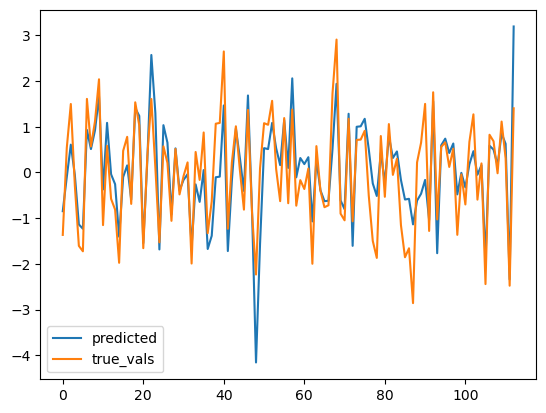

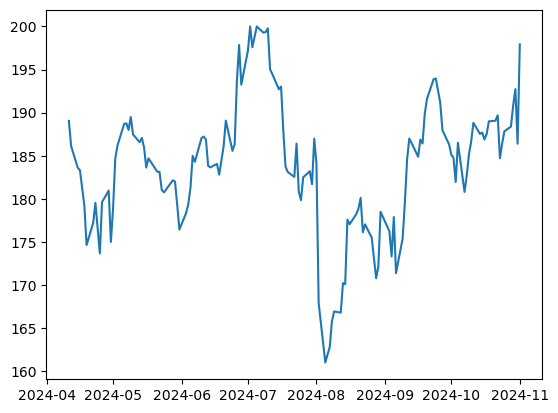

In [1310]:
import matplotlib.pyplot as plt
plt.clf()
with torch.no_grad():
    predicted = model(X_test)
plt.plot(predicted, label = "predicted")
plt.plot(y_test, label = "true_vals")
plt.legend()
plt.show()
plt.plot(prices_test, label = "prices")



In [1311]:
#Generate Signals:
def generate_signals(pred,actual):
    diff = actual - pred
    return diff.squeeze()

In [1312]:
diff = generate_signals(predicted, (y_test))

In [1313]:
diff

tensor([-0.5185,  0.6398,  0.8894, -0.2314, -0.4689, -0.4931,  0.6792,  0.0577,
         0.1982,  0.3725, -0.7796, -0.5029, -0.5374, -0.5561, -0.5700,  0.5717,
         0.6247, -0.0922,  0.1256, -0.2059, -0.1102,  0.0899, -0.9625, -1.1893,
         0.1551, -0.4626, -0.4406, -0.1429, -0.0124, -0.0845,  0.0851,  0.2567,
        -0.3639,  0.7087,  0.4810,  0.8225,  0.3450,  0.7516,  1.1712,  1.1748,
         1.1812,  0.4875,  0.3972,  0.0469, -0.2642, -0.4084, -0.3160, -0.0516,
         1.9237,  1.6558,  0.5462,  0.5313,  0.4833, -0.4552, -0.7885,  0.0406,
        -0.7728, -0.6826, -0.6201, -0.4834, -0.5449, -0.2476, -0.9270,  0.2944,
        -0.0088, -0.1324, -0.0988,  1.2120,  0.9680, -0.2895, -0.2429, -0.1089,
         0.5360, -0.2875, -0.2908, -0.2624, -1.0124, -1.2574, -1.3538,  0.3682,
        -0.3106,  0.2619, -0.3696, -0.1602, -0.9877, -1.2627, -1.0818, -1.7227,
         0.8362,  1.1165,  1.6631, -0.2385,  0.1992,  0.7384, -0.0344, -0.0811,
        -0.3052, -0.1122, -0.8852, -0.03

In [1314]:
diff = pd.DataFrame(predicted - y_test)
print(f"max: {diff.max()}")
print(f"min: {diff.min()}")
print(f"mean: {diff.mean()}")
print(f"std: {diff.std()}")


max: 0    1.789691
dtype: float32
min: 0   -1.923711
dtype: float32
mean: 0    0.038955
dtype: float32
std: 0    0.68279
dtype: float32


In [1315]:
def buy_signal(diff, threshold = -0.1):
    return (diff < threshold)

In [1316]:
signals = buy_signal(diff)

In [1317]:
signals.sum()/signals.shape[0]

0    0.362832
dtype: float64

In [1318]:
nbuys = int(signals.sum())


In [1319]:
def generate_pnl(signals, price_vec):
    pnl = []
    for index in range(len(signals)-1):
        if signals[0][index]:
            pnl.append((price_vec[index+1]-price_vec[index])*1)
    return pnl

In [1320]:
pnl = generate_pnl(signals,prices_test)

In [1321]:
pnl

[-2.510009765625,
 -0.29998779296875,
 2.5999908447265625,
 -2.9499969482421875,
 -2.9199981689453125,
 1.4900054931640625,
 2.489990234375,
 -0.7599945068359375,
 -2.3600006103515625,
 1.399993896484375,
 -2.6999969482421875,
 -2.8800048828125,
 1.899993896484375,
 1.0,
 1.94000244140625,
 3.720001220703125,
 -0.6999969482421875,
 2.7599945068359375,
 0.1699981689453125,
 -0.339996337890625,
 2.9799957275390625,
 -3.5099945068359375,
 0.769989013671875,
 7.2700042724609375,
 4.2400054931640625,
 -1.7700042724609375,
 -0.6199951171875,
 -0.5800018310546875,
 2.649993896484375,
 0.9099884033203125,
 3.029998779296875,
 1.160003662109375,
 0.660003662109375,
 1.2299957275390625,
 0.9099884033203125,
 -1.5399932861328125,
 -6.5,
 4.0099945068359375,
 -0.5099945068359375,
 -1.600006103515625,
 -0.45001220703125]

In [1322]:
tot = [0]
for p in pnl:
    tot.append((tot[-1]+p))
tot

[0,
 -2.510009765625,
 -2.80999755859375,
 -0.2100067138671875,
 -3.160003662109375,
 -6.0800018310546875,
 -4.589996337890625,
 -2.100006103515625,
 -2.8600006103515625,
 -5.220001220703125,
 -3.82000732421875,
 -6.5200042724609375,
 -9.400009155273438,
 -7.5000152587890625,
 -6.5000152587890625,
 -4.5600128173828125,
 -0.8400115966796875,
 -1.540008544921875,
 1.2199859619140625,
 1.389984130859375,
 1.04998779296875,
 4.0299835205078125,
 0.519989013671875,
 1.28997802734375,
 8.559982299804688,
 12.79998779296875,
 11.029983520507812,
 10.409988403320312,
 9.829986572265625,
 12.47998046875,
 13.389968872070312,
 16.419967651367188,
 17.579971313476562,
 18.239974975585938,
 19.469970703125,
 20.379959106445312,
 18.8399658203125,
 12.3399658203125,
 16.349960327148438,
 15.8399658203125,
 14.239959716796875,
 13.789947509765625]

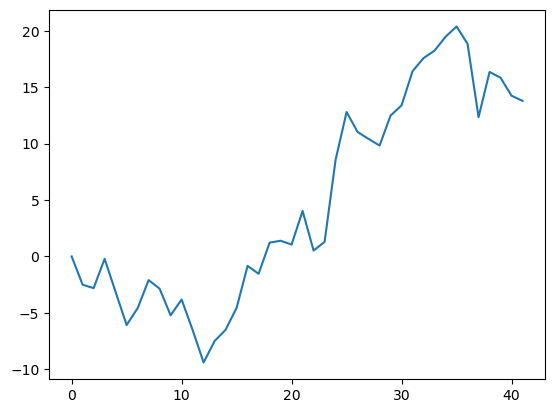

In [1323]:
plt.plot(tot)

In [1324]:
ndays =y_test.shape[0]
ndays

113

In [1334]:
import random
index = [i for i in range(ndays)]
ind = random.sample(index,nbuys)

In [1335]:
randomized_tot=[0]
for i in ind:
    if (i!=ndays):
        curr = prices_test[i+1] - prices_test[i]
        randomized_tot.append(randomized_tot[-1] + curr)

    
    

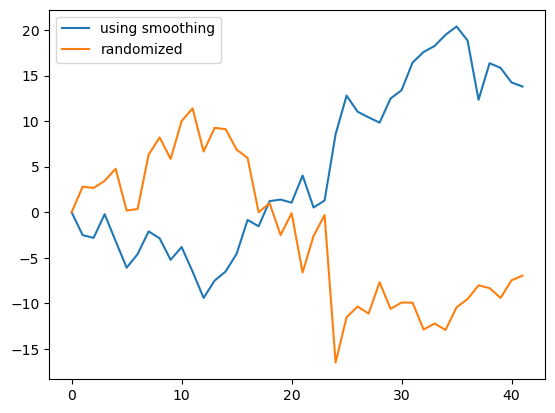

In [1336]:
plt.plot(tot, label = "using smoothing")
plt.plot(randomized_tot, label = 'randomized')
plt.legend()
plt.show()